# 04. PyTorch Custom Datasets

How do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.2.2


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 clases of food and only 10% of the images ( aprox 75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary. The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Downlaod data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading data...")
    f.write(requests.content)

# Unzip file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)

/Users/admin/courses/PyTorch-Fundamentals/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


data/pizza_steak_sushi directory already exists... skipping download


Unzipping data...


## 2. Becoming one with the data

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

1. Get all of the image paths
2. Pick a random image path using Python's randon.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with images, let's open Python's PIL
5. We'll then show the image and print metadata

data/pizza_steak_sushi/test/pizza/2236338.jpg
pizza
Height:  512
Width:  512


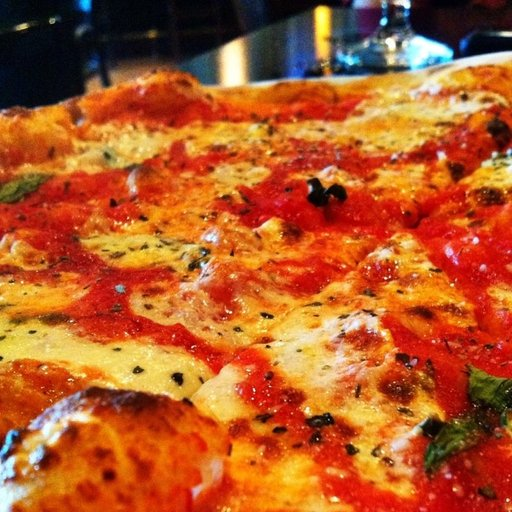

In [7]:
import random
from PIL import Image

random.seed(42)

# 1.
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2.
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3.
image_class = random_image_path.parent.stem
print(image_class)

# 4.
img = Image.open(random_image_path)

# 5.
print('Height: ', img.height)
print('Width: ', img.width)
img

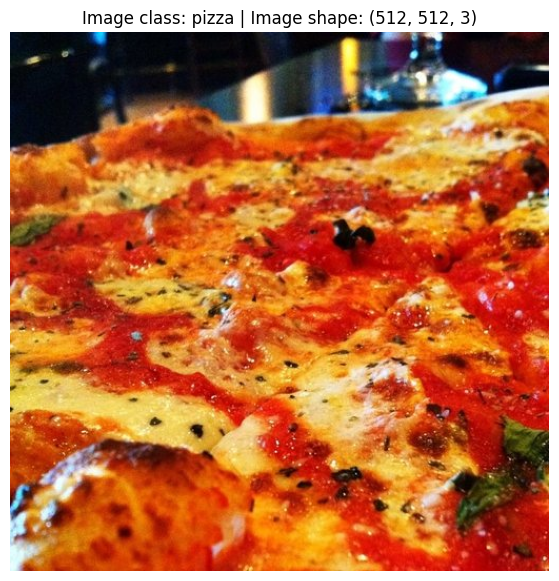

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False);

## 3. Transforming data

1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transform data with torchvision.transforms

Transforms help you to get your images ready to be used with a model and/or perform data augmentation.

In [10]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64 x 64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

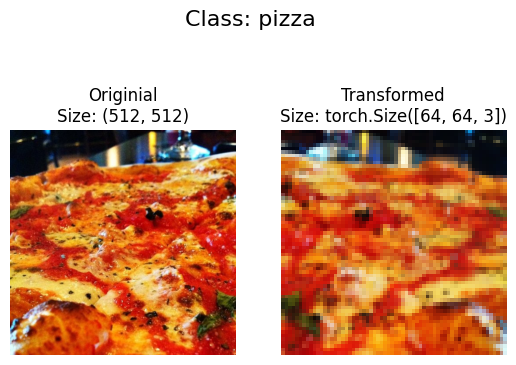

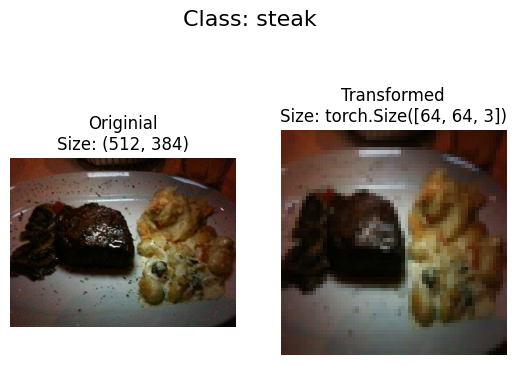

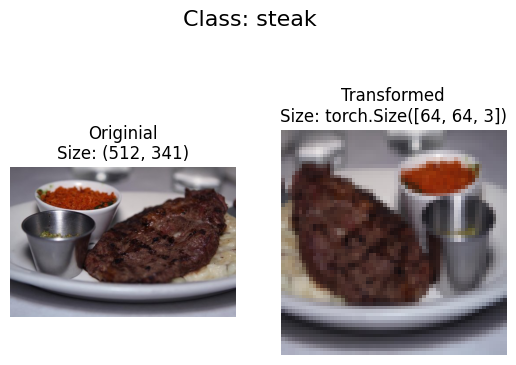

In [12]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
    """
    Selects randoms images from a path images and loads/transforms them
    then plots the origina vs the transformed version
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Originial\nSize: {f.size}")
            ax[0].axis(False)

            # Transfor and plot target image
            transformed_image = transform(f).permute(1,2,0) # Change in shape (C,H,W) -> (H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform)

## 4. Option 1: Loading image data using `ImageFolder`

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [17]:
# Index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img

tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0902, 0.0902, 0.

In [18]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [C, H, W]
Image permute: torch.Size([64, 64, 3]) -> [H, W, C]


(-0.5, 63.5, 63.5, -0.5)

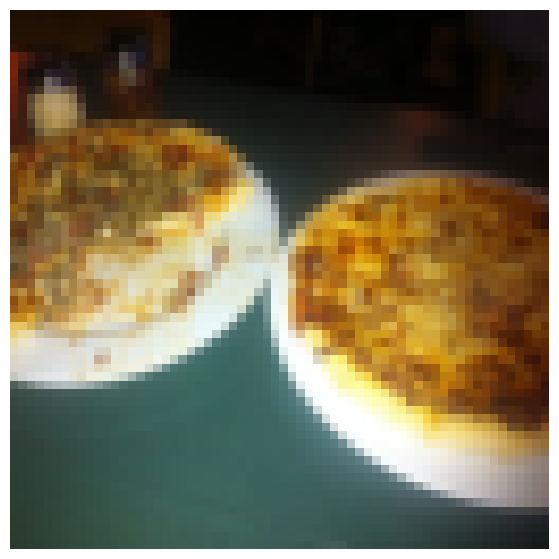

In [19]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out the shapes
print(f"Original shape: {img.shape} -> [C, H, W]")
print(f"Image permute: {img_permute.shape} -> [H, W, C]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)

### 4.1 Turn loaded images into `DataLoader`'s

In [20]:
# Turn train and test dataset into DataLoader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x11d54bf70>,
 <torch.utils.data.dataloader.DataLoader at 0x11d54bf10>)

## 5 Option 2: Loading Image Data with Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standar image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Return the class names into a dict and a list and return them.

In [23]:
# Setup path for the target directory
target_directory = train_dir

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


['pizza', 'steak', 'sushi']

In [24]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Find the class folder name in a target directory

    Args:
        directory (str): _description_

    Returns:
        Tuple[List[str], Dict[str, int]]: _description_
    """
    # 1. Get the class names
    classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

    # 2.
    if not classes:
        raise FileNotFoundError(f"Couldn't find any clases in {directory}")

    # 3.
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [25]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset``
2. Init our subclass with a target directory (the directory we'd like to get data from, as well as a transform if we'dlike to transform our data).
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes maped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` methos to return a given sample when passed an index

In [26]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1.
class ImageFolderCustom(Dataset):
    # 2.
    def __init__(self, targ_dir: str, transform=None):
        super().__init__()
        # 3.
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4.
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it.

        Args:
            index (int): _description_

        Returns:
            Image.Image: _description_
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5.
    def __len__(self) -> int:
        """Returns the total number of sampels."""
        return len(self.paths)

    # 6
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)."""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        return img, class_idx  # return untransformed data

In [27]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [28]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [29]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x11d54bb20>,
 <__main__.ImageFolderCustom at 0x11d54b850>)

### 5.3 Create a function to display random images

1. Take in a `Dataset` and number of other parameters such as class names and howmany images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [30]:
# 1.
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2.
    if n > 10:
        n = 10
        display_shape = True
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3.
    if seed:
        random.seed(seed)

    # 4.
    random_sample_idx = random.sample(range(len(dataset)), k = n)

    # 5
    plt.figure(figsize=(16, 8))

    # 6
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7.
        targ_image_adjust = targ_image.permute(1, 2, 0) # (H,W,C)

        # Plot adjusted sample
        plt.subplot(1, n, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Classes: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)
        plt.show()

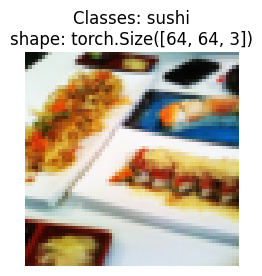

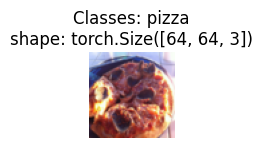

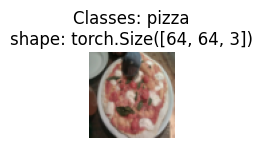

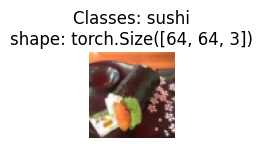

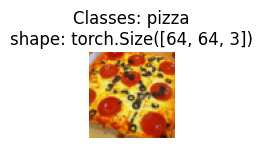

In [31]:
display_random_images(train_data,
                      n = 5,
                      classes=class_names,
                      seed=42)

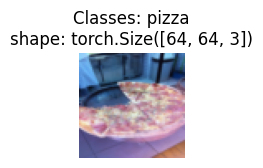

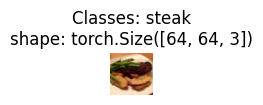

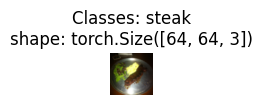

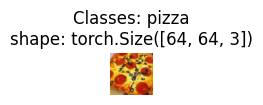

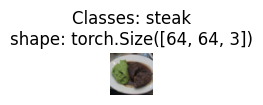

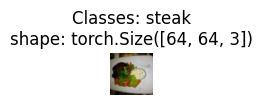

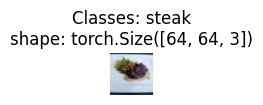

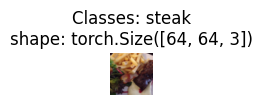

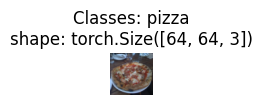

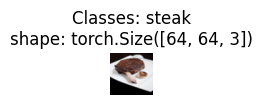

In [32]:
display_random_images(train_data_custom,
                      n = 10,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [33]:
from torch.utils.data import DataLoader


train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size= BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size= BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False)

In [34]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom

(torch.Size([32, 3, 64, 64]),
 tensor([2, 0, 0, 0, 1, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, 2,
         2, 0, 1, 0, 0, 2, 1, 2]))

## 6. Other form of transforms (data augmentation)

https://www.datacamp.com/tutorial/complete-guide-data-augmentation

In [35]:
from torchvision import transforms


train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [36]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

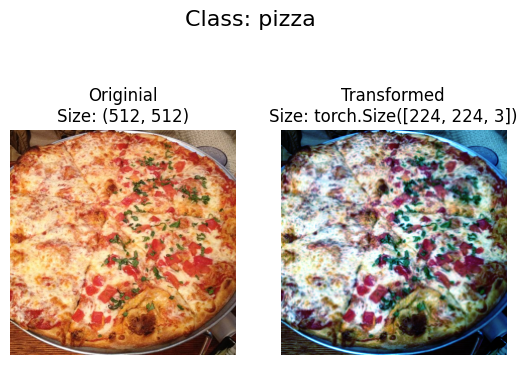

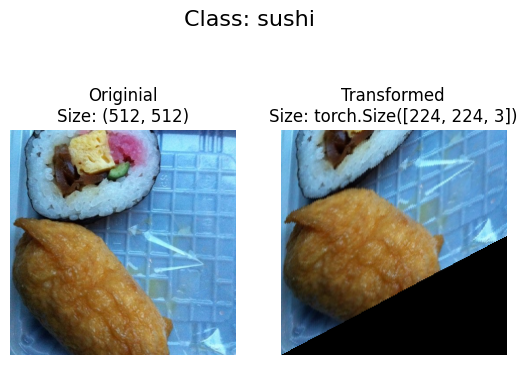

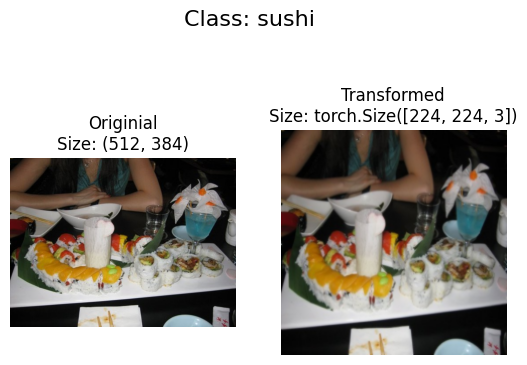

In [40]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)